# Expedia Hotel Recommendation System
***
## Datasets-
#### 1. Train dataset- Click and booking events from 2013 to 2014.
#### 2. Test dataset- Booking events in 2015.
#### 3. Destinations- Features extracted from hotel reviews text. 

## Data pre-processing and Analysis
***
### 1. Load the datasets:

In [1]:
import pandas as pd 
import numpy as np 

path_in1='F:/AML/Project/expedia-hotel-recommendations/train.csv' 
path_in2='F:/AML/Project/expedia-hotel-recommendations/test.csv'
path_in3='F:/AML/Project/expedia-hotel-recommendations/destinations.csv'

train_set=pd.read_csv(path_in1,nrows=3000000) #limiting no. of rows to avoid memory issues
test_set=pd.read_csv(path_in2)
destinations=pd.read_csv(path_in3)

### 2. Data Cleaning and Analysis:
#### Checking the train dataset - 

In [2]:
train_set.shape

(3000000, 24)

In [3]:
train_set.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [4]:
train_set.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

#### Check the unique values in "is_booking" column. This column gives information on whether an event is a click or booking event.

In [5]:
train_set["is_booking"].value_counts()

0    2757051
1     242949
Name: is_booking, dtype: int64

#### Since the test data has only booking events, we can filter out our data removing click events.

In [6]:
train_set=train_set[train_set["is_booking"]==1]
train_set["is_booking"].value_counts()

1    242949
Name: is_booking, dtype: int64

#### Let us check if all the user IDs in test dataset are present in train dataset. This will help us understand how much of our test data is without any history. This will help us understand our accuracy score better.

In [7]:
test_ids = set(test_set.user_id.unique())
print(len(test_ids))

1181577


In [8]:
train_ids = set(train_set.user_id.unique())
print(len(train_ids))

65216


In [9]:
intersection_count = len(test_ids & train_ids)
intersection_count

64322

#### From the counts above, we can see that almost all test IDs are present in the train dataset. We will now downsize the data by selecting 10000 unique user ids from train dataset and selecting the same users from test dataset as well.

In [10]:
import random
unique_users = train_set.user_id.unique()
selected_id = random.sample(list(unique_users),10000)
train_set_v1 = train_set[train_set.user_id.isin(selected_id)]

In [11]:
train_set_v1['user_id'].value_counts()

382953     97
254104     96
648512     87
628845     85
1082468    77
           ..
931370      1
528071      1
930671      1
930616      1
1100209     1
Name: user_id, Length: 10000, dtype: int64

In [12]:
train_set_v1.shape

(36982, 24)

#### Now let us select the test data for these user IDs.

In [13]:
test_set_v1=test_set[test_set.user_id.isin(selected_id)]

In [14]:
test_set_v1.shape

(23900, 22)

### 3. Feature Engineering:
#### Find out the null values-

In [15]:
train_set_v1.isna().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    12835
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                          0
srch_co                          0
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [16]:
train_set_v1.orig_destination_distance

158              NaN
268              NaN
276              NaN
306              NaN
331              NaN
             ...    
2999752          NaN
2999754          NaN
2999930    1100.5251
2999935    1500.2372
2999937    1500.2372
Name: orig_destination_distance, Length: 36982, dtype: float64

<Axes: ylabel='Density'>

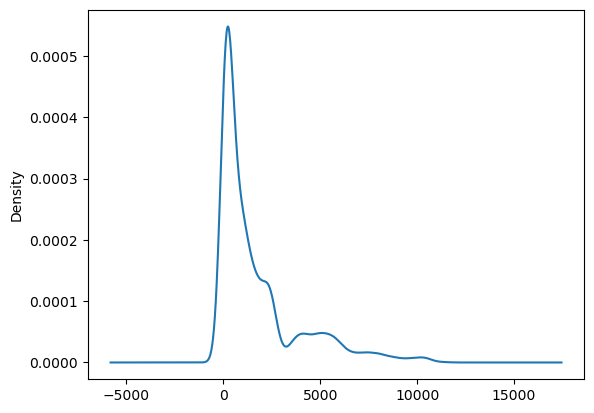

In [17]:
train_set_v1['orig_destination_distance'].plot(kind='kde')

#### To remove the null values-
#### We will update 'orig_destination_distance' with categories VERY_CLOSE,CLOSE,FAR,VERY_FAR.

In [18]:
def tag_distance(x):
    if x < 500:
        return 'VERY_CLOSE'
    elif x >=500 and x < 2000:
        return 'CLOSE'
    elif x >=2000 and x < 6000:
        return 'FAR'
    else:
        return 'VERY_FAR'
# work on origin_destination_distance
print('Discretizing origin_destination_distance column')
train_set_v1.orig_destination_distance = train_set_v1.orig_destination_distance.apply(lambda x: tag_distance(x))

Discretizing origin_destination_distance column


C:\Users\User-\AppData\Local\Temp\ipykernel_14216\3712480703.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_v1.orig_destination_distance = train_set_v1.orig_destination_distance.apply(lambda x: tag_distance(x))


In [19]:
train_set_v1.isna().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

#### Update date columns datatype and add new columns: 

In [20]:
train_set_v1['srch_ci'] = pd.to_datetime(train_set_v1['srch_ci'])
train_set_v1['srch_co'] = pd.to_datetime(train_set_v1['srch_co'])
train_set_v1['date_time'] = pd.to_datetime(train_set_v1['date_time'])
train_set_v1['stay_dur'] = (train_set_v1['srch_co'] - train_set_v1['srch_ci']).astype('timedelta64[D]')

C:\Users\User-\AppData\Local\Temp\ipykernel_14216\3505105627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_v1['srch_ci'] = pd.to_datetime(train_set_v1['srch_ci'])
C:\Users\User-\AppData\Local\Temp\ipykernel_14216\3505105627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_v1['srch_co'] = pd.to_datetime(train_set_v1['srch_co'])
C:\Users\User-\AppData\Local\Temp\ipykernel_14216\3505105627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [21]:
train_set_v1['no_of_days_before_booking'] = (train_set_v1['srch_ci'] - train_set_v1['date_time']).astype('timedelta64[D]')
train_set_v1['current_mon'] = train_set_v1['date_time'].dt.month
train_set_v1['current_year'] = train_set_v1['date_time'].dt.year
train_set_v1['srch_ci_day'] = train_set_v1['srch_ci'].dt.day
train_set_v1['srch_ci_mon'] = train_set_v1['srch_ci'].dt.month
train_set_v1['srch_ci_year'] = train_set_v1['srch_ci'].dt.year
train_set_v1['srch_co_mon'] = train_set_v1['srch_co'].dt.month
train_set_v1['srch_co_year'] = train_set_v1['srch_co'].dt.year

C:\Users\User-\AppData\Local\Temp\ipykernel_14216\2621576082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_v1['no_of_days_before_booking'] = (train_set_v1['srch_ci'] - train_set_v1['date_time']).astype('timedelta64[D]')
C:\Users\User-\AppData\Local\Temp\ipykernel_14216\2621576082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_v1['current_mon'] = train_set_v1['date_time'].dt.month
C:\Users\User-\AppData\Local\Temp\ipykernel_14216\2621576082.py:3: SettingWithCopyWarning: 
A valu

In [22]:
train_set_v1 = train_set_v1.drop(columns=['date_time','srch_ci','srch_co',])

#### Convert orig_destination_distance column from categorical to numerical-

In [23]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() 
train_set_v1['orig_destination_distance'] = label_encoder.fit_transform(train_set_v1['orig_destination_distance'])

#### Destinations dataset-
##### This dataset has 149 columns and all the features are converted to numbers which describe a particular destination id. These features have no labels on them to understand the interpretation. We can use prinipal component analysis (PCA) to reduce our features and still preserve the variance per row.

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5) #reducing the columns to 5
dest_v1 = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_v1 = pd.DataFrame(dest_v1)
dest_v1["srch_destination_id"] = destinations["srch_destination_id"]

#### Merge destinations data to the training set

In [25]:
train_set_v2 = pd.merge(train_set_v1, dest_v1, on='srch_destination_id', how='left')
train_set_v2.replace(np.nan, 0, inplace=True)

In [26]:
train_set_v2 = train_set_v2.reset_index(drop=True)
train_set_v2.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_ci_day,srch_ci_mon,srch_ci_year,srch_co_mon,srch_co_year,0,1,2,3,4
0,24,2,3,64,12576,3,2451,0,0,4,...,26,2,2014,2,2014,0.406384,-0.035756,-0.085351,0.084639,-0.101098
1,24,2,3,64,9448,3,2451,0,0,4,...,4,2,2015,2,2015,0.000000,0.000000,0.000000,0.000000,0.000000
2,24,2,3,64,9448,3,2451,0,0,4,...,10,2,2015,2,2015,0.633453,-0.201750,-0.104658,0.149841,-0.139221
3,24,2,3,64,9448,3,2451,0,0,4,...,7,2,2015,2,2015,0.346895,-0.138010,-0.309934,0.167468,-0.007366
4,24,2,3,64,9448,3,2451,0,0,4,...,8,2,2015,2,2015,0.385035,-0.423696,-0.509905,0.191807,-0.015865


## Modelling-
***
#### Understanding the relationship with hotel_clusters-

In [27]:
train_set_v2["hotel_cluster"].value_counts()

91    1417
48    1115
59     892
42     845
28     765
      ... 
87      79
92      72
53      45
74      40
27      29
Name: hotel_cluster, Length: 100, dtype: int64

#### This shows that cluster number and its count have no relation and they are almost fairly distributed. 
#### Let us now check hotel_cluster correlation with the other features-

In [28]:
train_set_v2.corr()["hotel_cluster"]

site_name                   -0.000483
posa_continent              -0.007735
user_location_country       -0.021498
user_location_region         0.001602
user_location_city          -0.001510
orig_destination_distance    0.009079
user_id                      0.011716
is_mobile                    0.000147
is_package                   0.006233
channel                      0.004628
srch_adults_cnt              0.005352
srch_children_cnt            0.010583
srch_rm_cnt                 -0.002825
srch_destination_id         -0.004606
srch_destination_type_id    -0.025486
is_booking                        NaN
cnt                         -0.003309
hotel_continent              0.005621
hotel_country                0.004526
hotel_market                 0.038320
hotel_cluster                1.000000
stay_dur                     0.042957
no_of_days_before_booking    0.014818
current_mon                  0.004033
current_year                -0.001139
srch_ci_day                  0.004281
srch_ci_mon 

#### hotel_cluster doesn't have strong correlation with any of the features. Hence, Linear regression/ Logistic Regression will not be suited for our dataset.

#### 1. Random Forest Algorithm-

In [35]:
train_set_v2.rename(columns={'0': 'd0', '1': 'd1','2': 'd2', '3': 'd3','4': 'd4'}, inplace=True)
train_set_v2.columns = train_set_v2.columns.astype(str)
train_set_v2.columns

Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster',
       'stay_dur', 'no_of_days_before_booking', 'current_mon', 'current_year',
       'srch_ci_day', 'srch_ci_mon', 'srch_ci_year', 'srch_co_mon',
       'srch_co_year', 'd0', 'd1', 'd2', 'd3', 'd4'],
      dtype='object')

In [36]:
predictors = [c for c in train_set_v2.columns if c not in ["hotel_cluster"]]
from sklearn.model_selection import cross_validate

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, min_weight_fraction_leaf=0.1)
scores = cross_validate(clf, train_set_v2[predictors], train_set_v2["hotel_cluster"], cv=2)
scores

{'fit_time': array([2.13986301, 2.0576973 ]),
 'score_time': array([1.39041471, 1.34388852]),
 'test_score': array([0.08723163, 0.08441945])}

#### 2.KNN-

In [41]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=20)
scores = cross_validate(knn_model, train_set_v2[predictors], train_set_v2["hotel_cluster"], cv=2)
scores

{'fit_time': array([0.01209903, 0.01563334]),
 'score_time': array([0.83707476, 1.00965643]),
 'test_score': array([-0.07215501, -0.07039477])}

















#### Make initial plots to understand how the bookings are distributed-

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#### Which country has the highest bookings? 

[Text(0.5, 1.0, 'Top 30 countries by bookings')]

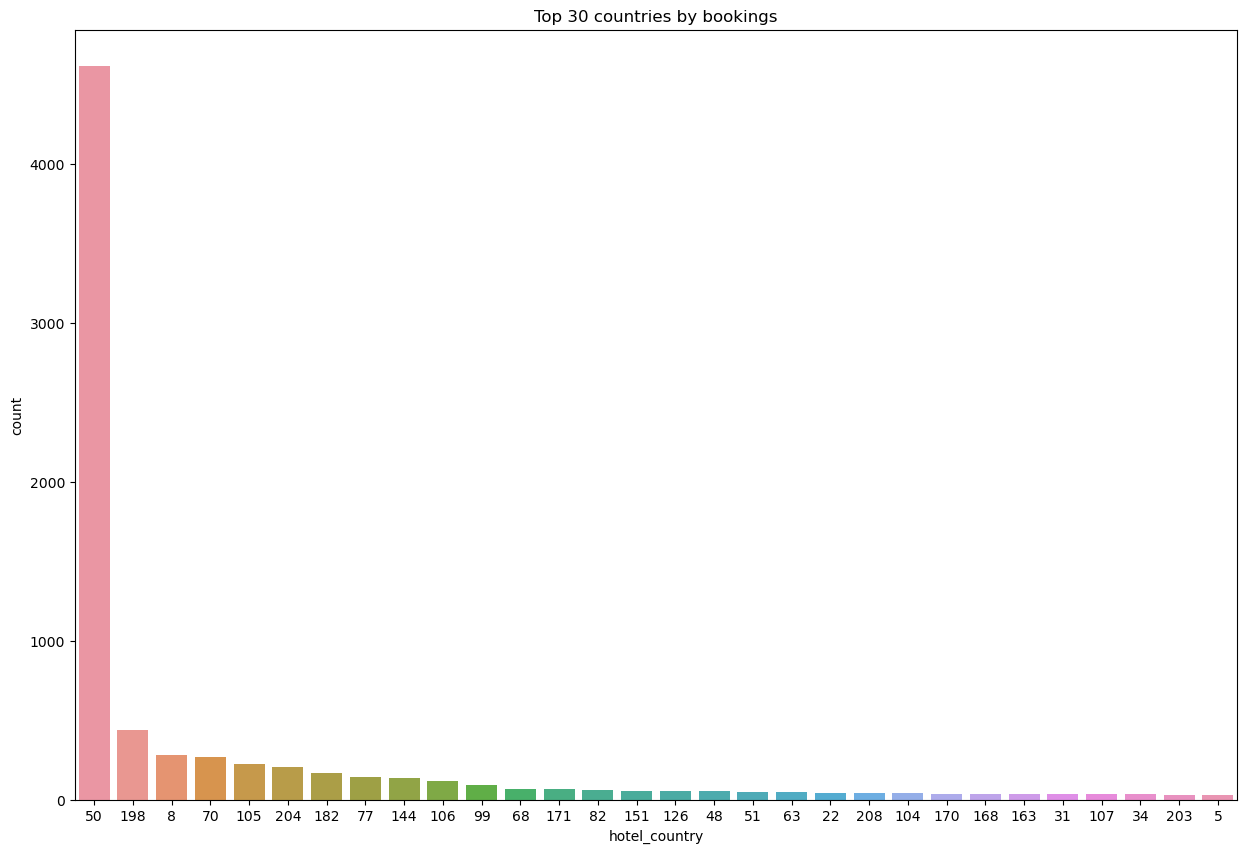

In [68]:
plt.figure(figsize=(15,10))
sns.countplot(x='hotel_country',data=train_set,order=train_set.value_counts(train_set['hotel_country']).iloc[:30].index).set(title="Top 30 countries by bookings")

#### Where are most of the customers from? 

[Text(0.5, 1.0, 'Top 30 countries based on customer base')]

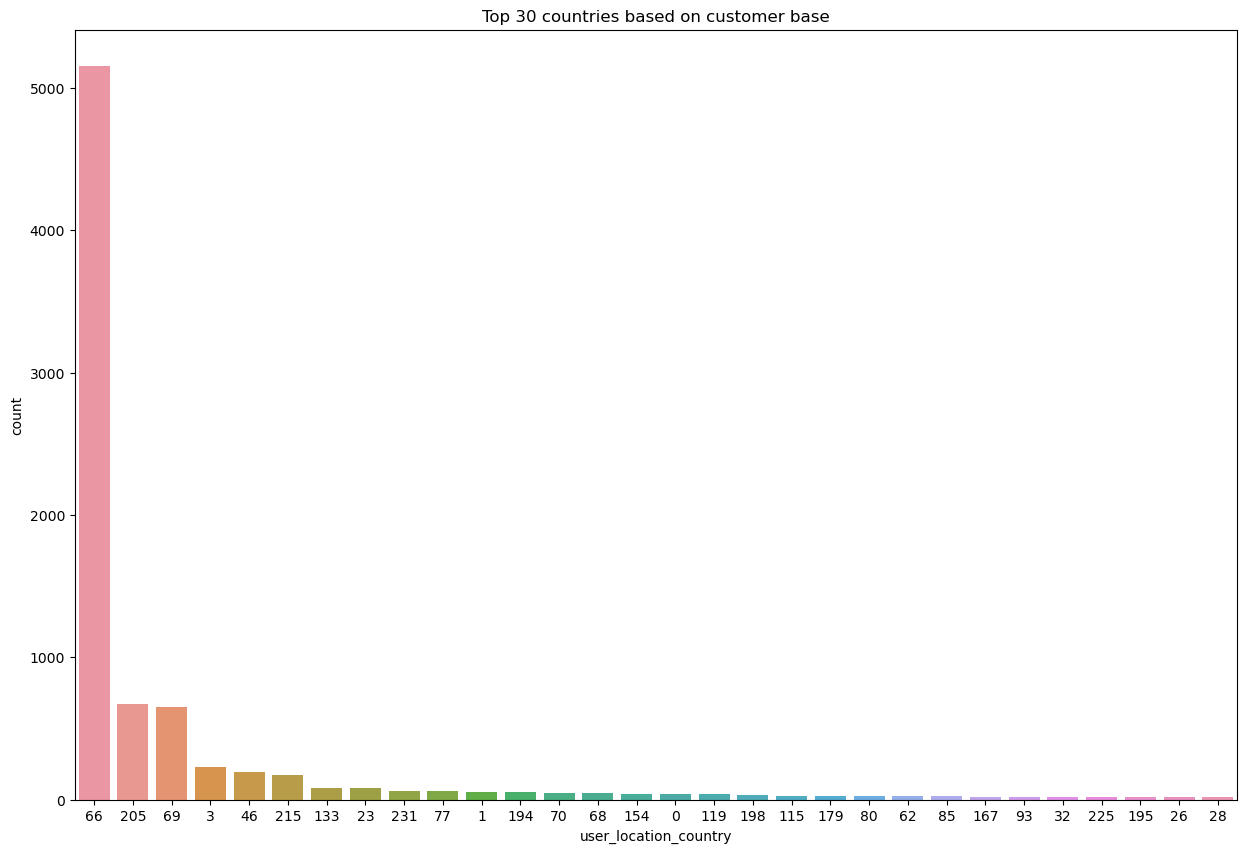

In [69]:
plt.figure(figsize=(15,10))
sns.countplot(x='user_location_country',data=train_set,order=train_set.value_counts(train_set['user_location_country']).iloc[:30].index).set(title="Top 30 countries based on customer base")

#### Frequency of each hotel cluster? 

[Text(0.5, 1.0, 'Top 30 clusters')]

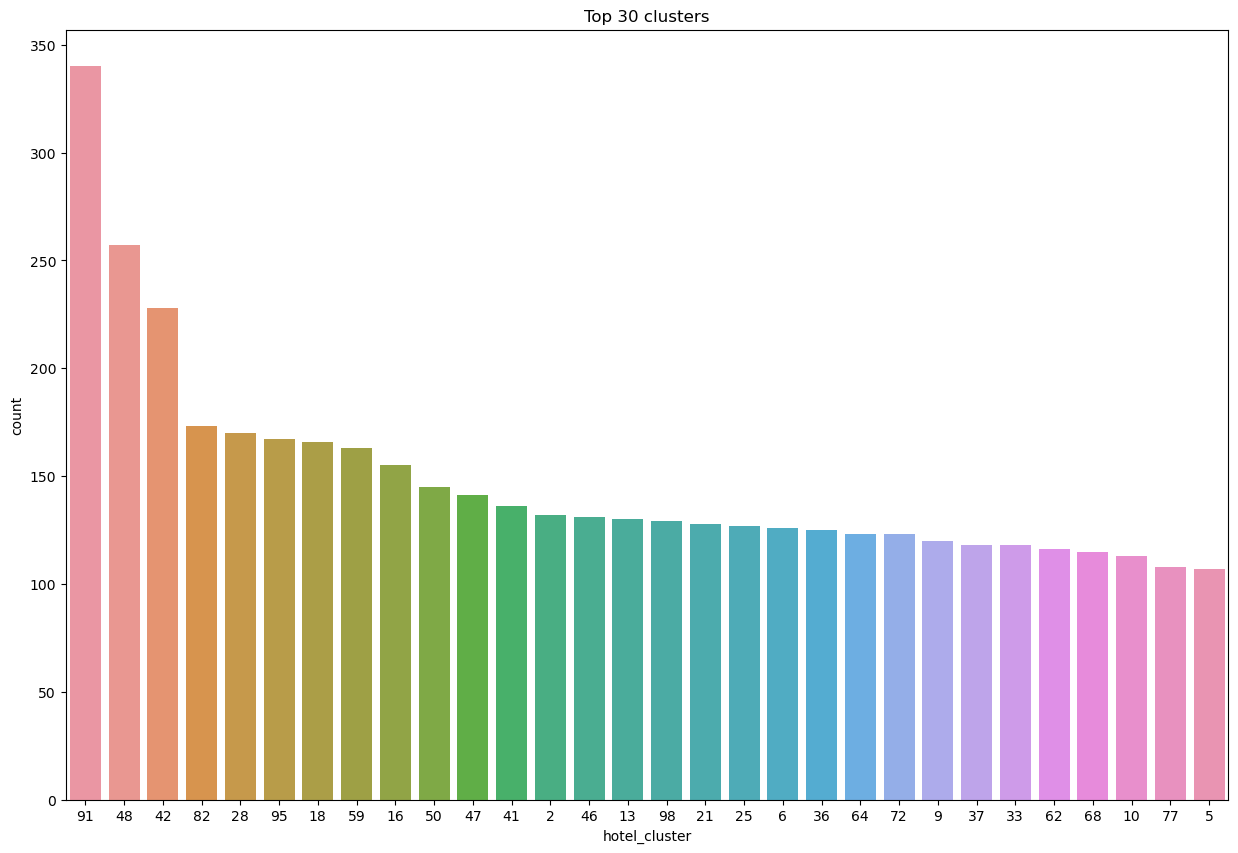

In [70]:
plt.figure(figsize=(15,10))
sns.countplot(x='hotel_cluster',data=train_set,order=train_set.value_counts(train_set['hotel_cluster']).iloc[:30].index).set(title="Top 30 clusters")

#### The most frequent hotel clusters in the highest booked country?

[Text(0.5, 1.0, 'Top 30 clusters for highest booked country')]

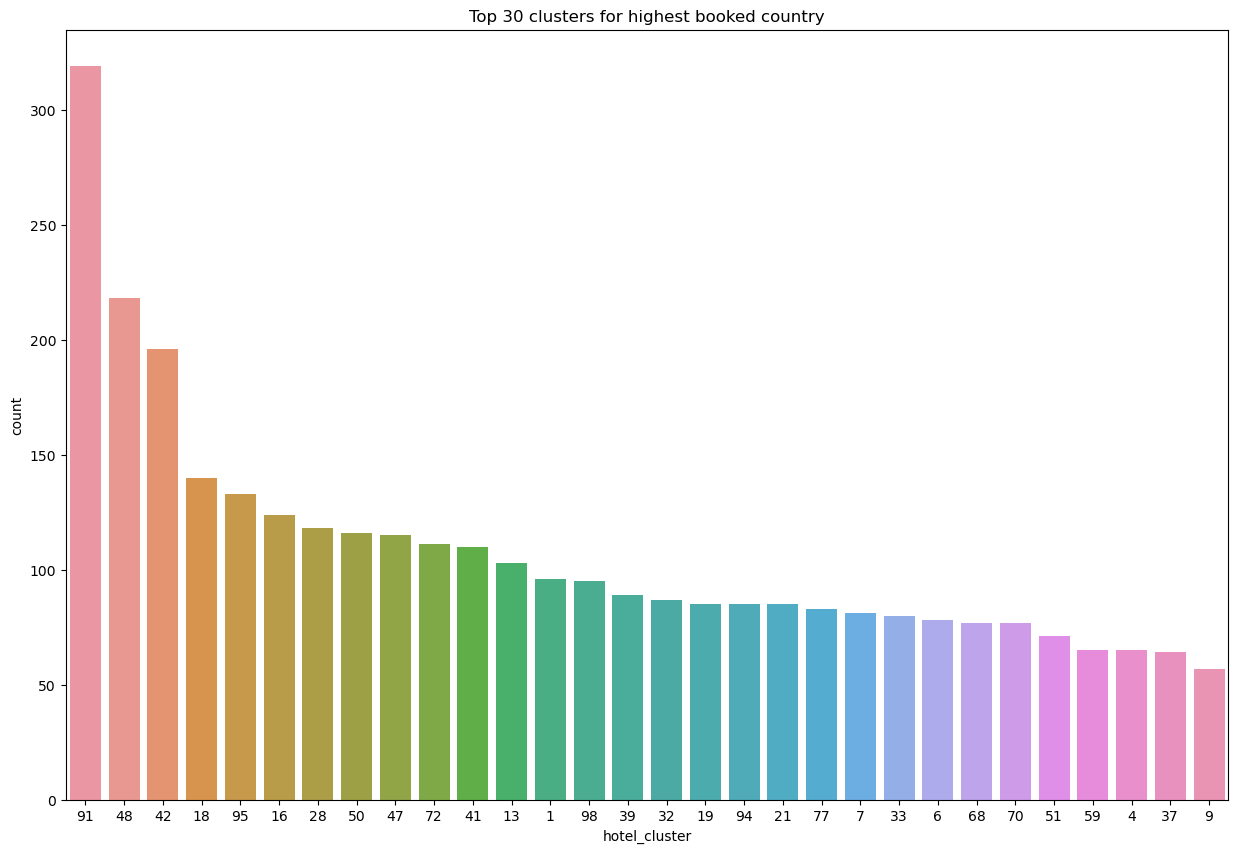

In [71]:
cluster_data=train_set[train_set['hotel_country']==50]
plt.figure(figsize=(15,10))
sns.countplot(x='hotel_cluster',data=cluster_data,order=cluster_data.value_counts(cluster_data['hotel_cluster']).iloc[:30].index).set(title="Top 30 clusters for highest booked country")

#### Are most bookings through mobile or other devices?
#### For reference- Booking by mobile-1, Booking by other devices-0

[Text(0.5, 1.0, 'Bookings by device')]

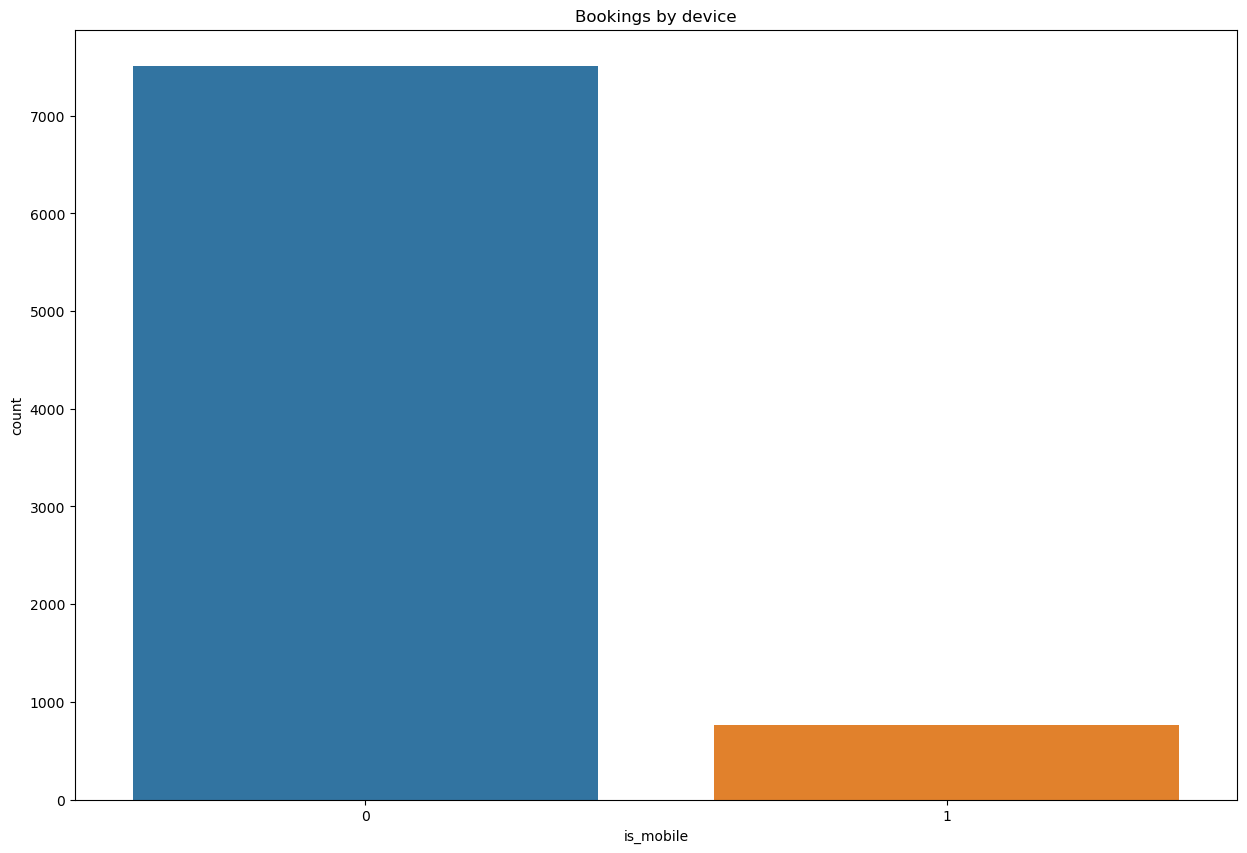

In [74]:
plt.figure(figsize=(15,10))
sns.countplot(x='is_mobile',data=train_set).set(title="Bookings by device")

#### Based on the above analysis, we can make few more transformations on the data and prepare the model. Changes include-
#### - Adding more features like the change the data type for date columns, calculate no. of days of stay in the hotel.
#### - Filling up the null values in the columns.
#### - Change data types wherever required.